In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [6]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 16.0 MB/s eta 0:00:00


In [7]:
import py7zr

for dirname, _, filenames in os.walk('/kaggle/input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        archive = py7zr.SevenZipFile(os.path.join(dirname, filename), mode='r')
        archive.extractall(path="/kaggle/working")
        archive.close()

In [8]:
from subprocess import check_output

print(check_output(["ls", "../working"]).decode("utf8"))

holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



# **EDA**

In [9]:
holiday_events = pd.read_csv("../working/holidays_events.csv", parse_dates=['date'])
items = pd.read_csv("../working/items.csv")
oil = pd.read_csv("../working/oil.csv", parse_dates=['date'])
stores = pd.read_csv("../working/stores.csv")

train = pd.read_csv("../working/train.csv", nrows=6000000  , parse_dates=['date'])
train_large = pd.read_csv('../working/train.csv', skiprows = 115000000, names = train.columns, parse_dates = ['date'])
transactions = pd.read_csv("../working/transactions.csv", parse_dates=['date'])

In [10]:
train.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
5,5,2013-01-01,25,108786,3.0,NaN
6,6,2013-01-01,25,108797,1.0,NaN
7,7,2013-01-01,25,108952,1.0,NaN
8,8,2013-01-01,25,111397,13.0,NaN
9,9,2013-01-01,25,114790,3.0,NaN


In [11]:
# import pandas as pd

# def check_null_values(datasets, dataset_names=None):
#     """
#     Check and display null values for each dataset.
    
#     Parameters:
#     - datasets (list of pd.DataFrame): A list of pandas DataFrames to check for null values.
#     - dataset_names (list of str, optional): Names of the datasets for labeling in the output. 
#       If not provided, default names will be assigned.
      
#     Returns:
#     - dict: A dictionary where keys are dataset names and values are DataFrames summarizing null values.
#     """
#     if dataset_names is None:
#         dataset_names = [f"Dataset_{i+1}" for i in range(len(datasets))]
#     elif len(dataset_names) != len(datasets):
#         raise ValueError("The number of dataset names must match the number of datasets.")
    
#     null_summary = {}
    
#     for name, df in zip(dataset_names, datasets):
#         null_counts = df.isnull().sum()
#         null_percent = (null_counts / len(df)) * 100
#         summary = pd.DataFrame({
#             'Column': null_counts.index,
#             'Null Count': null_counts.values,
#             'Null Percentage (%)': null_percent.values
#         }).sort_values(by='Null Count', ascending=False)
#         null_summary[name] = summary
#         print(f"Null Value Summary for {name}:\n")
#         print(summary)
#         print("-" * 50)
    
#     return null_summary


In [12]:
# datasets = [holiday_events, items, oil, stores, train, transactions ]
# dataset_names = ["holiday_events", "items", "oil", "stores", "train", "transactions"]

# # Check null values
# null_summary = check_null_values(datasets, dataset_names)

In [13]:
# Import necessary libraries
import pandas as pd

# List of datasets
datasets = {
    "holiday_events": holiday_events,
    "items": items,
    "oil": oil,
    "stores": stores,
    "train": train,
    "train_large": train_large,
    "transactions": transactions,
}

# Function to inspect each dataset
def inspect_datasets(datasets):
    for name, df in datasets.items():
        print(f"--- {name.upper()} ---")
        print(f"Shape: {df.shape}")
        print("First 5 rows:")
        print(df.head(), "\n")
        print("Info:")
        print(df.info(), "\n")
        print("Summary Statistics (Numerical Features):")
        print(df.describe(), "\n")
        print("Missing Values:")
        print(df.isnull().sum(), "\n")
        print("=" * 50)

# Run the inspection
inspect_datasets(datasets)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

--- HOLIDAY_EVENTS ---
Shape: (350, 6)
First 5 rows:
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False   

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  3

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


                 id                           date     store_nbr  \
count  6.000000e+06                        6000000  6.000000e+06   
mean   3.000000e+06  2013-03-14 16:53:41.150400256  2.657089e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    1.500000e+06            2013-02-07 00:00:00  1.100000e+01   
50%    3.000000e+06            2013-03-15 00:00:00  2.700000e+01   
75%    4.499999e+06            2013-04-19 00:00:00  4.300000e+01   
max    5.999999e+06            2013-05-24 00:00:00  5.400000e+01   
std    1.732051e+06                            NaN  1.649155e+01   

           item_nbr    unit_sales  onpromotion  
count  6.000000e+06  6.000000e+06          0.0  
mean   6.300631e+05  8.545289e+00          NaN  
min    9.699500e+04 -2.070000e+02          NaN  
25%    3.585150e+05  2.000000e+00          NaN  
50%    6.278870e+05  4.000000e+00          NaN  
75%    8.887610e+05  9.000000e+00          NaN  
max    1.150954e+06  1.007400e+04          N

In [14]:
# This is an extensive Exploratory Data Analysis for the Corporación Favorita Grocery Sales Forecasting competition with tidy R and ggplot2.

# The aim of this challenge is to forecast more accurate product sales for the Ecuadorian supermarket chain Corporación Favorita.

# The data comes in the shape of multiple files. First, the training data (../input/train.csv) essentially contains the sales by date, store, and item. The test data (../input/test.csv) contains the same features without the sales information, which we are tasked to predict. The train vs test split is based on the date. In addition, some test items are not included in the train data.

# Furthermore, there are 5 additional data files that provide the following information:

# stores.csv: Details about the stores, such as location and type.

# items.csv: Item metadata, such as class and whether they are perishable. Note, that perishable items have a higher scoring weight than others.

# transactions.csv: Count of sales transactions for the training data

# oil.csv: Daily oil price. This is relevant, because “Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.” (source)

# holidays_events.csv: Holidays in Ecuador. Some holidays can be transferred to another day (possibly from weekend to weekday).

# In addition, the data description notes the importance of public sector pay days (on the 15th and the end of the month) as well as the impact of a major earthquake on April 16 2016.

In [15]:
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [16]:
# We find:

# There is a unique id to label our observations. The date feature will need to be transformed to a better format.

# The store numbers are integers (store_nbr) ranging from 1 to 54. Item numbers (item_nbr) are also encoded as integers. Both of these features will work better when encoded as factors.

# onpromotion is a logical feature, describing whether the item in question had been assigned a special promotion pricing at the time in the specific store. This feature contains many NA values.

# unit_sales is our target feature: How many units of the specific item were sold in that store on that day. Negative values mean that this particular item was returned (source).

In [17]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [18]:
# Stores are identified by their city (e.g. “Quito”) and state (e.g. “Pichincha”), according to their store_nbr which connects this information to the train/test data. Along with the type of the store, these should be encoded as factors.

# cluster describes a “grouping of similar stores” (source). We will find out what exactly that means.

In [19]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [20]:
# The items are grouped into a broad family (e.g. “BREAD/BAKERY”) and an integer class column. Once more, these will be factors.

# perishable, an identifier whether the item will go bad over time. It is encoded as an integer but would work better as a logical feature, since the only values appear to be “0 vs 1”: perishable (e.g. milk) vs not perishable (e.g. DVDs).

# item_nbr is of course the key column relating this data set to train/test

In [21]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [22]:
# This data set gives us an additional total number of transactions per store_nbr for a given date. This information is only available for the training data.

In [23]:
oil.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [24]:
# We find that this is a simple time series of the oil price at a given date. There are a few NAs in the price (dcoilwtico) column. The date feature should be re-formated.

In [25]:
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [26]:
# Holidays and special events also come in the shape of a time series with a date column.

# There is a type of the holiday, a qualifier whether it’s regional (locale) and in which region it applies (locale_name), as well as the name of the holiday in the feature description.

# transferred is a logical column indicating whether this specific holiday was moved to a different day that year.

In [27]:
# Missing values:

# train contains the majority of readily accessible NAs in the onpromotion feature.

# oil contains another 43 NAs for unknown oil prices.

# **Oil**

In [28]:
oil.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


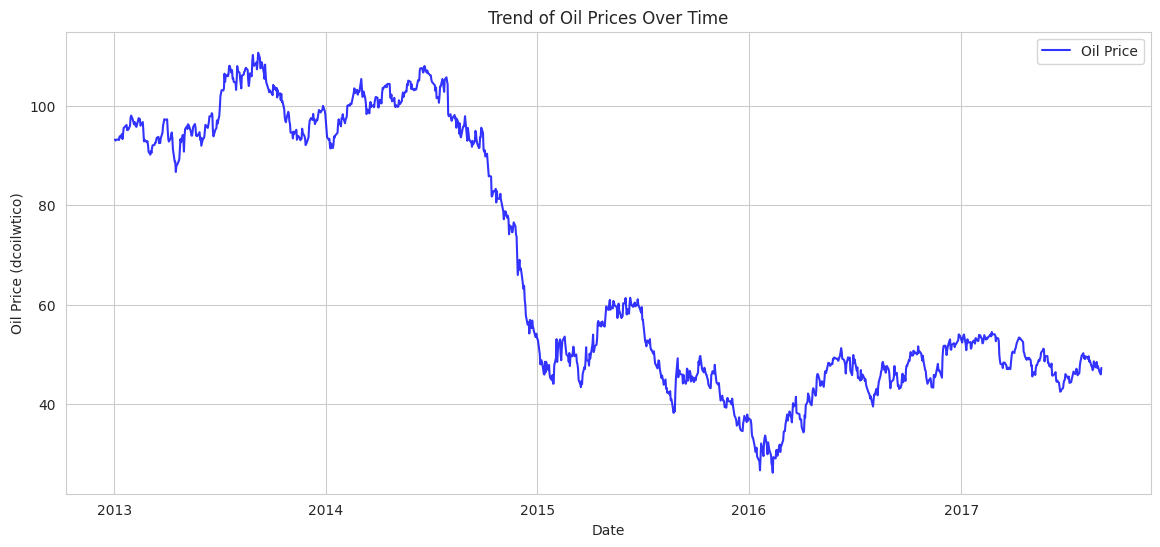

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Drop null values in 'dcoilwtico' column
oil_cleaned = oil.dropna(subset=['dcoilwtico'])

# Plot the trend
plt.figure(figsize=(14, 6))
plt.plot(oil_cleaned['date'], oil_cleaned['dcoilwtico'], label='Oil Price', color='blue', alpha=0.8)
plt.title("Trend of Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Oil Price (dcoilwtico)")
plt.grid(True)
plt.legend()
plt.show()

In [30]:
# There are strong, long-term changes in oil price with an obvious drop in the second half of 2014. Overlayed on this long-term trend appear to be fluctuations on time scales of weeks and months.

# The frequent downward trends are visible in the week-to-week variations. The strong dips and rises in the lower plot might have a stronger influence on buying behaviour than the long-term evolution.

# **Stores**

In [31]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


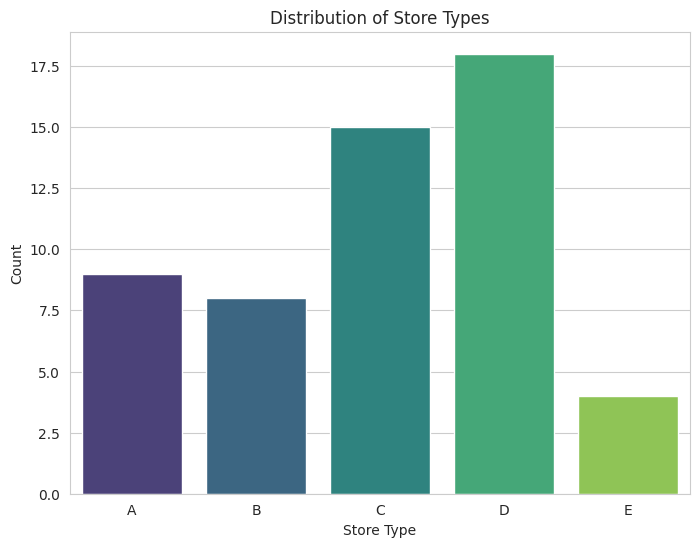

In [32]:
import seaborn as sns

plt.figure(figsize=(8, 6))

# Sort the unique values of 'type' column in ascending order
sorted_types = sorted(stores['type'].unique())

sns.countplot(data=stores, x='type', palette='viridis', order=sorted_types)

plt.title("Distribution of Store Types")
plt.xlabel("Store Type")
plt.ylabel("Count")
plt.show()


In [33]:
# Among the types, we see that D and “C” are the most frequent, with “A” and “B” having similar medium frequency and “E” only accounting for 4 stores.

In [34]:
import plotly.express as px

# Create a treemap to visualize the distribution of stores by city
fig = px.treemap(stores, 
                 path=['city'],  # Hierarchical path
                 title="Distribution of Stores by City",
                 color='city',  # Color by city for better distinction
                 hover_data=['city'],  # Show city on hover
                 color_continuous_scale='Set2')  # Color palette

# Show the plot
fig.show()


In [35]:
import plotly.express as px

# Create a treemap to visualize the distribution of stores by state
fig = px.treemap(stores, 
                 path=['state'],  # Hierarchical path
                 title="Distribution of Stores by State",
                 color='state',  # Color by state for better distinction
                 hover_data=['state'],  # Show state on hover
                 color_continuous_scale='Set3')  # Color palette

# Show the plot
fig.show()


In [36]:
# The city distribution is reflected in the state distribution as well, with “Pichincha” having 19 stores, “Guayas” 11, and the rest between 1 and 3.

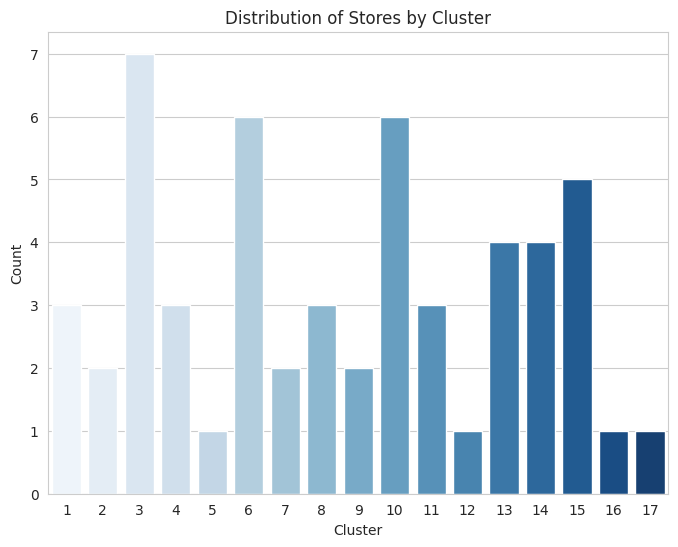

In [37]:
plt.figure(figsize=(8, 6))
sns.countplot(data=stores, x='cluster', palette='Blues')
plt.title("Distribution of Stores by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [38]:
# Create a new column combining city and state
stores['city_state'] = stores['city'] + '_ ' + stores['state']

# Show the first few rows of the new column
stores[['city', 'state', 'city_state']].head()


,city,state,city_state
0,Quito,Pichincha,Quito_ Pichincha
1,Quito,Pichincha,Quito_ Pichincha
2,Quito,Pichincha,Quito_ Pichincha
3,Quito,Pichincha,Quito_ Pichincha
4,Santo Domingo,Santo Domingo de los Tsachilas,Santo Domingo_ Santo Domingo de los Tsachilas


In [39]:
fig = px.treemap(stores, 
                 path=['state', 'city'],  # Group by state, then city
                 values='store_nbr',  # Size by store_nbr (count of stores)
                 title="Treemap of Cities Grouped by States")

fig.show()

In [40]:
# I find that most states only contain stores in a single city, but that “Los Rios”, “Manabi” and “Pichincha” contain two and “Guayays” has four cities with Favorita stores.

type                                           A  B  C  D  E
city_state                                                  
Ambato_ Tungurahua                             1  0  0  1  0
Babahoyo_ Los Rios                             0  1  0  0  0
Cayambe_ Pichincha                             0  1  0  0  0
Cuenca_ Azuay                                  0  1  0  2  0
Daule_ Guayas                                  0  0  0  1  0
El Carmen_ Manabi                              0  0  1  0  0
Esmeraldas_ Esmeraldas                         0  0  0  0  1
Guaranda_ Bolivar                              0  0  1  0  0
Guayaquil_ Guayas                              1  1  2  2  2
Ibarra_ Imbabura                               0  0  1  0  0
Latacunga_ Cotopaxi                            0  0  2  0  0
Libertad_ Guayas                               0  0  0  0  1
Loja_ Loja                                     0  0  0  1  0
Machala_ El Oro                                0  0  1  1  0
Manta_ Manabi           

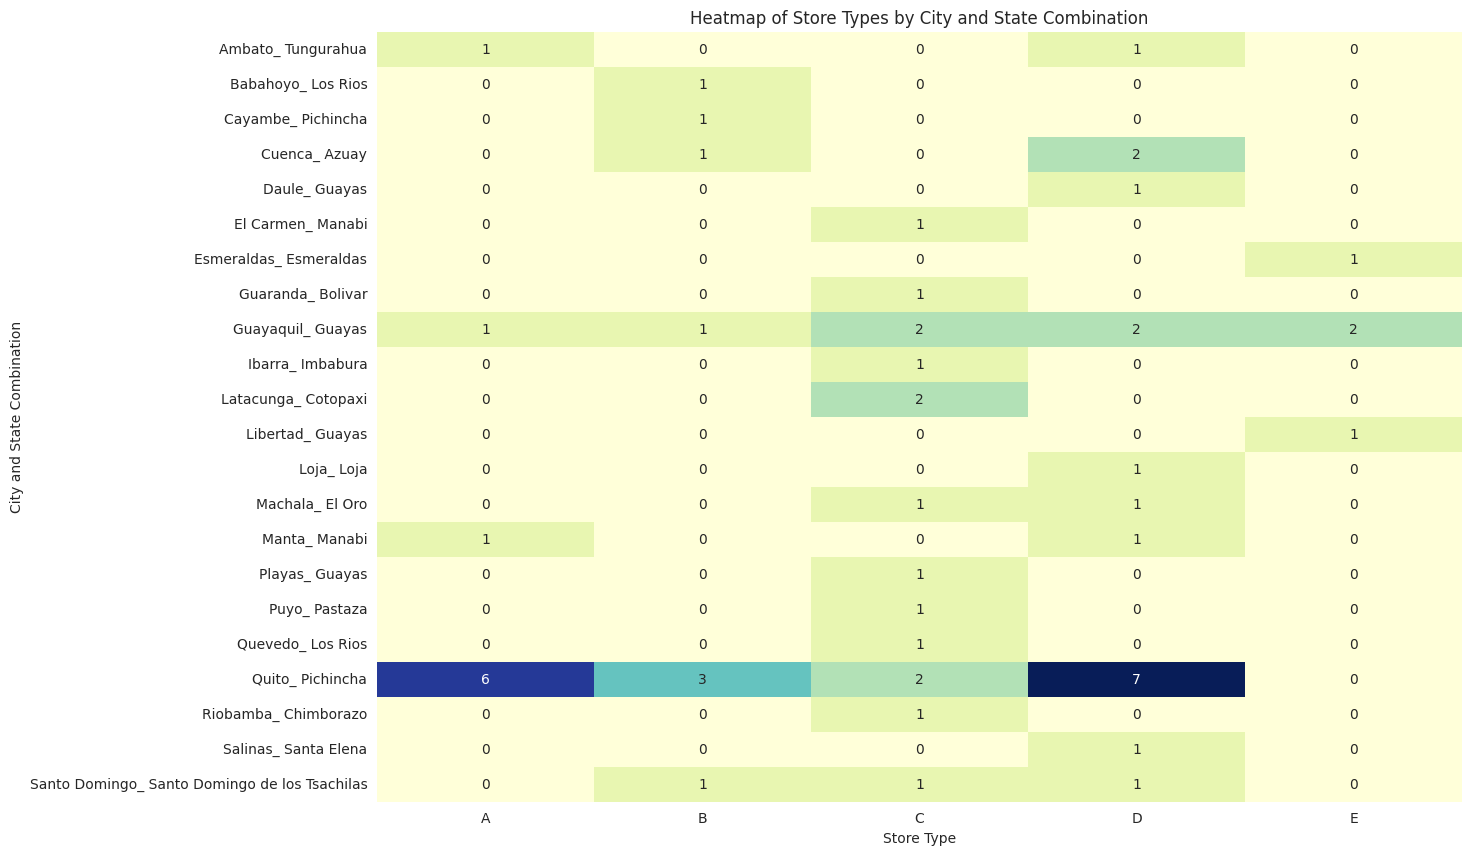

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a cross-tabulation to show the city_state combination against store type
city_state_type_combination = pd.crosstab(stores['city_state'], stores['type'])

# Display the cross-tabulation table
print(city_state_type_combination)

# Plot the heatmap for city-state and type combination
plt.figure(figsize=(14, 10))
sns.heatmap(city_state_type_combination, annot=True, fmt="d", cmap='YlGnBu', cbar=False)
plt.title("Heatmap of Store Types by City and State Combination")
plt.xlabel("Store Type")
plt.ylabel("City and State Combination")
plt.show()


<Figure size 1400x800 with 0 Axes>

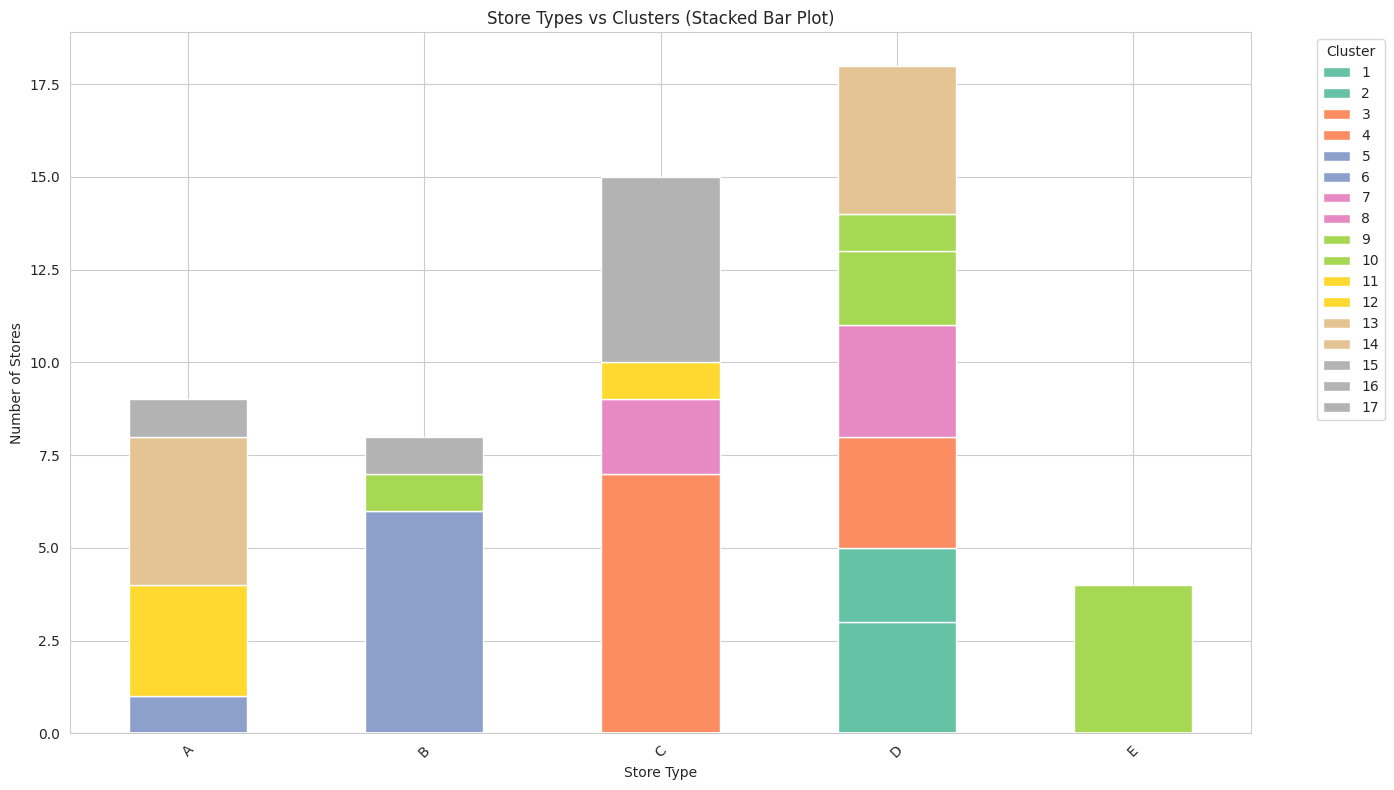

In [42]:
# Group by store type and cluster, and count the number of stores
store_type_cluster_count = stores.groupby(['type', 'cluster']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
store_type_cluster_count.plot(kind='bar', stacked=True, colormap='Set2', figsize=(14, 8))

# Customize the plot
plt.title('Store Types vs Clusters (Stacked Bar Plot)')
plt.xlabel('Store Type')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

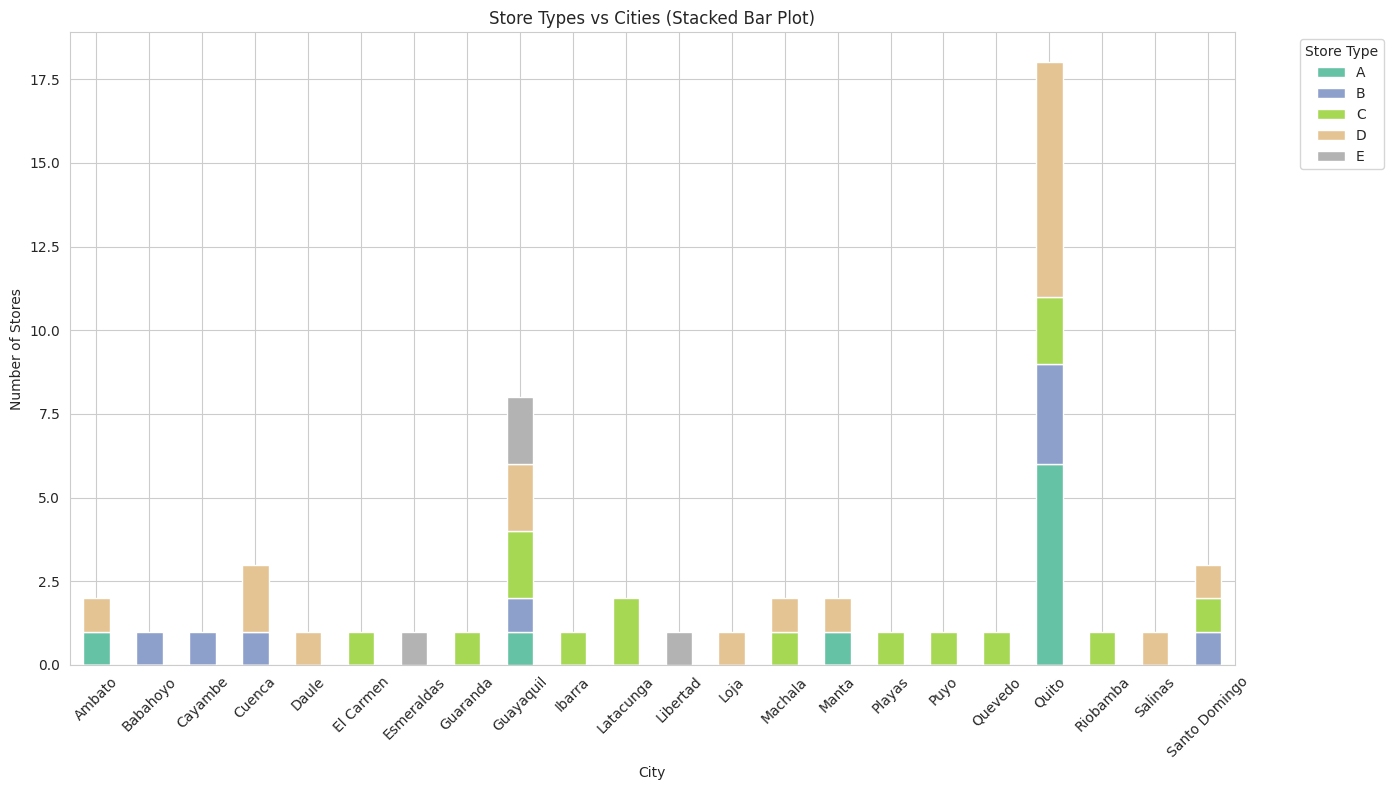

In [43]:
# Group by city and store type, and count the number of stores
city_store_type_count = stores.groupby(['city', 'type']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
city_store_type_count.plot(kind='bar', stacked=True, colormap='Set2', figsize=(14, 8))

# Customize the plot
plt.title('Store Types vs Cities (Stacked Bar Plot)')
plt.xlabel('City')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Holidays**

In [44]:
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


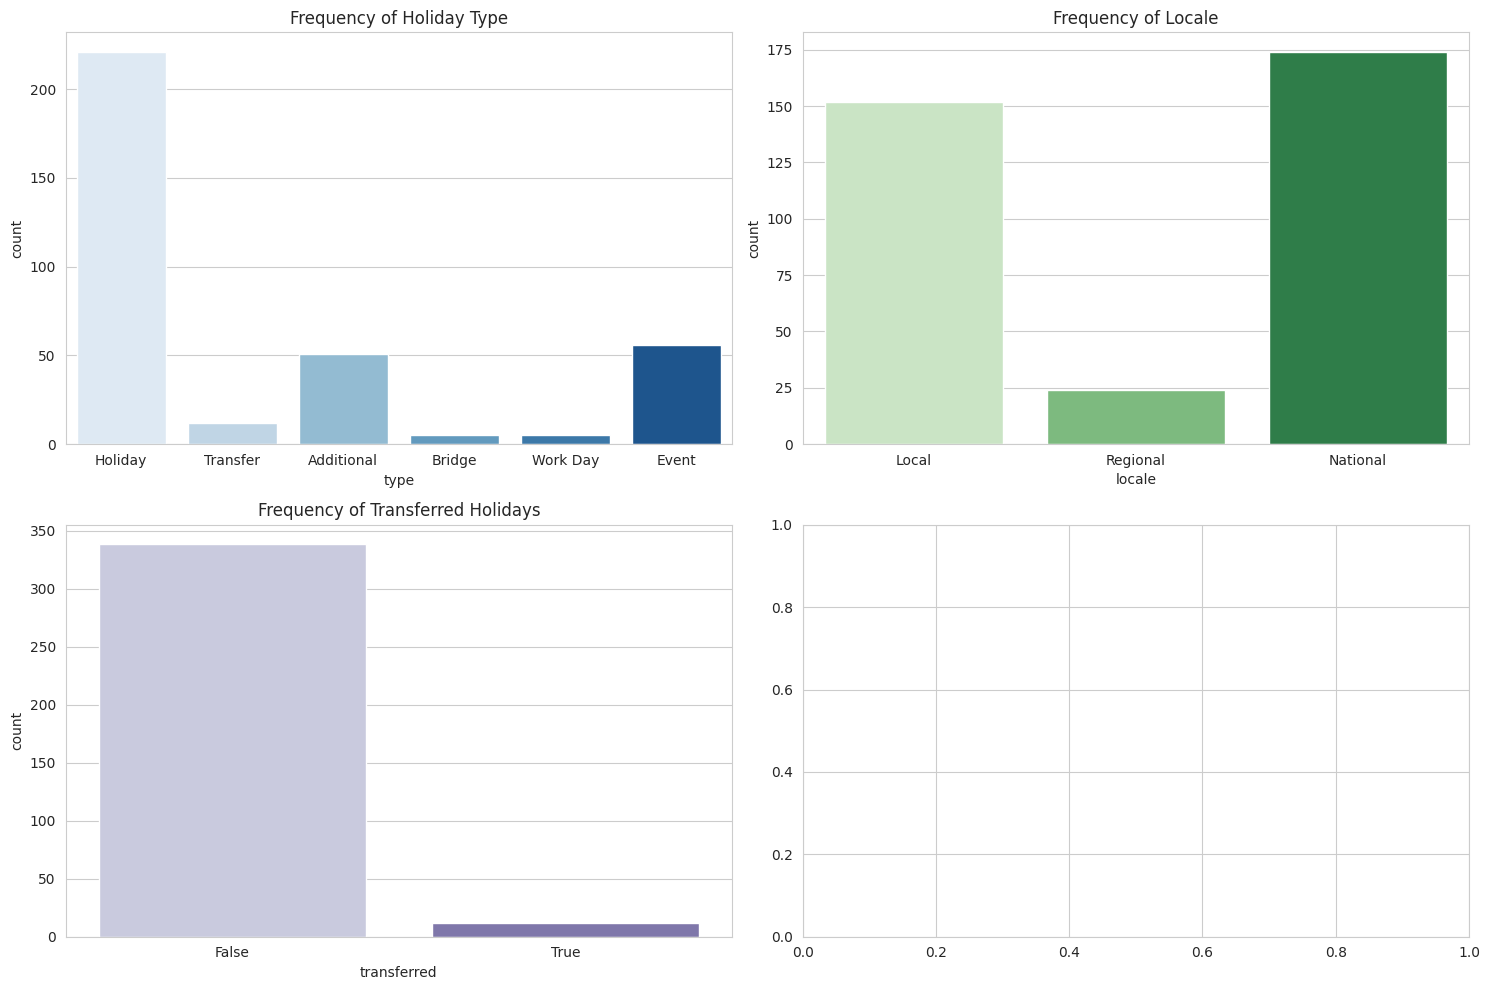

In [45]:

# Set Seaborn style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define columns and palettes
columns = ["type", "locale", "transferred"]
palettes = ["Blues", "Greens", "Purples"]
titles = ["Frequency of Holiday Type", "Frequency of Locale", "Frequency of Transferred Holidays"]

# Generate countplots dynamically
for i, (col, palette, title) in enumerate(zip(columns, palettes, titles)):
    row, col_idx = divmod(i, 2)  # Calculate subplot position
    sns.countplot(data=holiday_events, x=col, ax=axes[row, col_idx], palette=palette)
    axes[row, col_idx].set_title(title)

# Adjust layout
plt.tight_layout()
plt.show()


<ipython-input-46-43eacf40aca6>:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



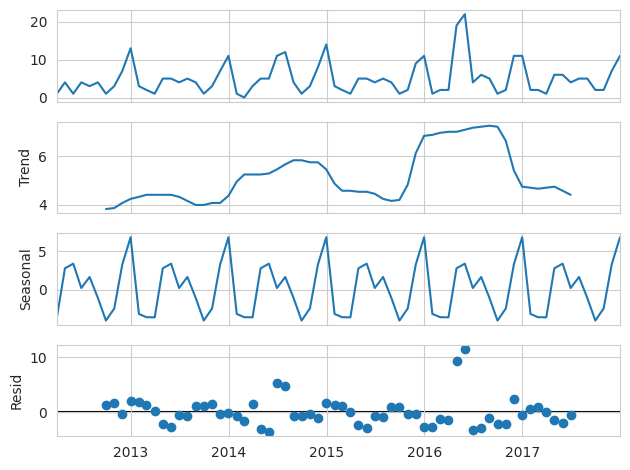

In [46]:
import statsmodels.api as sm

# Extract the year-month from 'date' to resample the data monthly
holiday_events.set_index('date', inplace=True)
holiday_monthly = holiday_events.resample('M').size()

# Decompose the time series (Trend + Seasonality + Noise)
decomposition = sm.tsa.seasonal_decompose(holiday_monthly, model='additive')
decomposition.plot()
plt.show()


In [47]:
# Mosts special days are of the type “Holiday” and are either of the locale “Local” or “National”. Relatively few “Regional” holidays are present in our data.

# The majority of days off is not transferred

# **items**

In [48]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



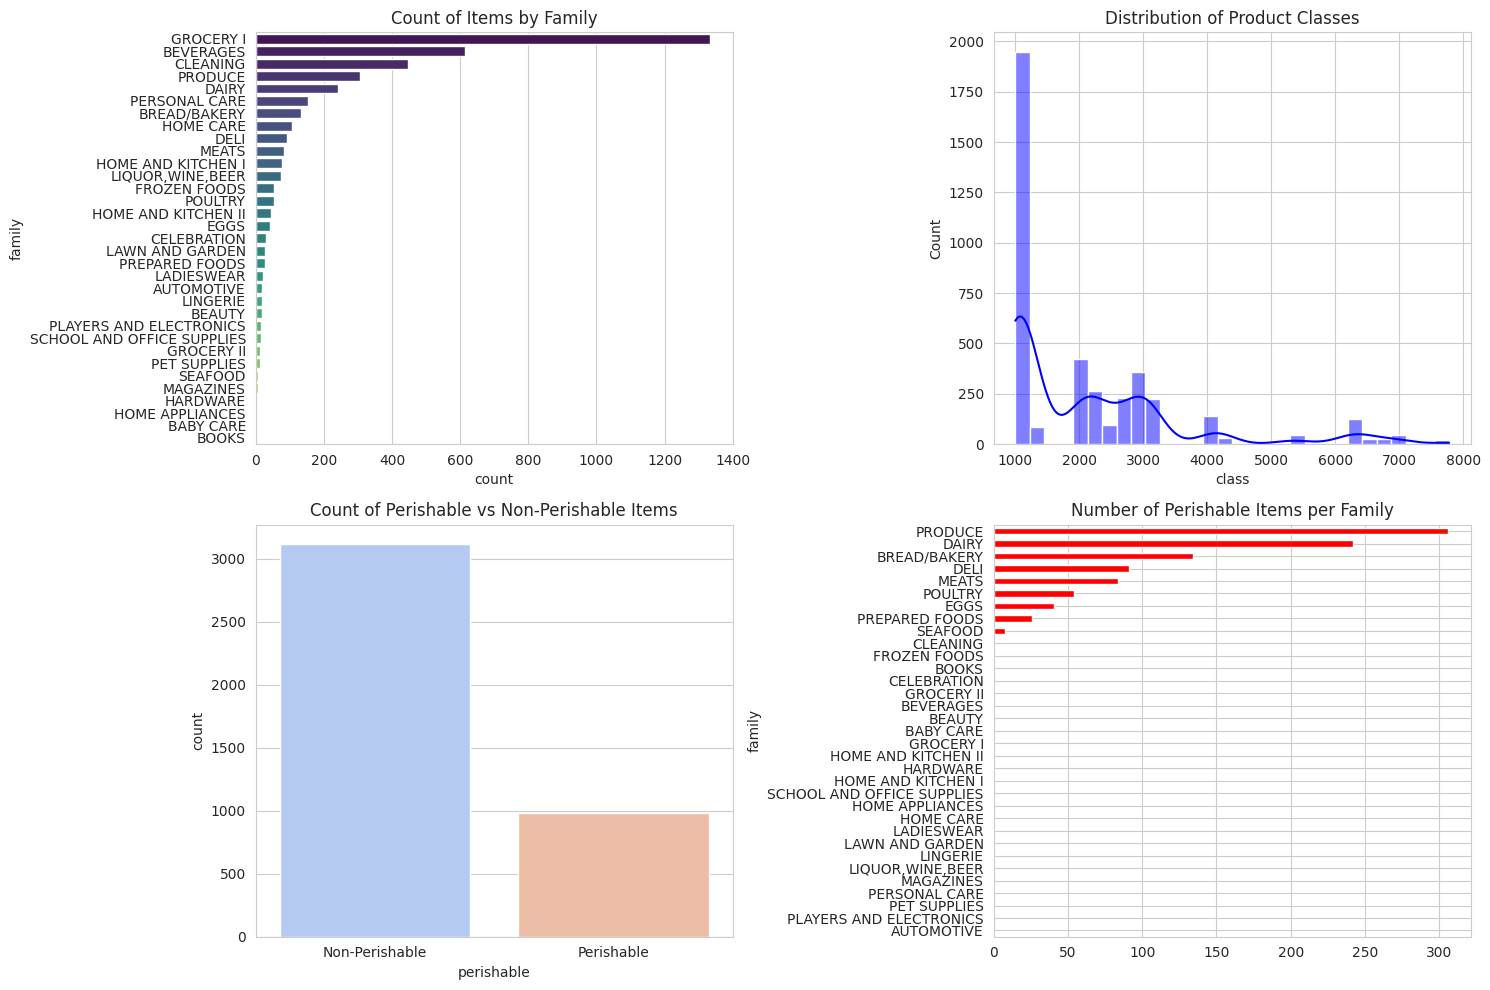

In [49]:
import seaborn as sns

sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Countplot of Product Families
sns.countplot(data=items, y="family", order=items["family"].value_counts().index, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Count of Items by Family")

# 2. Distribution of 'class'
sns.histplot(items["class"], bins=30, kde=True, ax=axes[0, 1], color="blue")
axes[0, 1].set_title("Distribution of Product Classes")

# 3. Perishable vs Non-Perishable Count
sns.countplot(data=items, x="perishable", ax=axes[1, 0], palette="coolwarm")
axes[1, 0].set_xticklabels(["Non-Perishable", "Perishable"])
axes[1, 0].set_title("Count of Perishable vs Non-Perishable Items")

# 4. Family-wise Perishable Count
perishable_family = items.groupby("family")["perishable"].sum().sort_values()
perishable_family.plot(kind="barh", ax=axes[1, 1], color="red")
axes[1, 1].set_title("Number of Perishable Items per Family")

# Adjust layout
plt.tight_layout()

image_path = '/kaggle/working/items_analysis.png'
plt.savefig(image_path)
plt.show()


In [50]:
# The class feature has a large number of levels, suggesting a detailed sub-division, with larger variation between a few and more than 100 cases (upper left). In the upper middle plot we show the most frequent item classes, with “1016” being the most popular code.

# About 1/4 of all items are perishable. This status will have a notable impact on our prediction models, because good predictions of perishable items are (understandably) rewarded with a bonus.

# The family of the items is a broad grouping into what would correspond to an aisle or a section of a supermarket (e.g. “DELI” or “PET SUPPLIES”). The dominant role of “GROCERY I” helps us to understand why there is a large fraction of perishable items.

In [51]:
# class_counts = items.groupby(["family", "class"]).size().reset_index(name="count")
# class_counts["log_count"] = np.log1p(class_counts["count"])  # Log scaling

# # Create treemap
# fig = px.treemap(
#     class_counts,
#     path=["family", "class"],  # Hierarchical structure: family → class
#     values="log_count",  # Log-transformed count
#     title="Treemap of Classes Grouped by Family (Log Scale)",
#     color="log_count",
#     color_continuous_scale="Blues",
#     hover_data={"class": True, "family": True, "log_count": False}  # Show family & class
# )

# # Update text labels to show family & class values
# fig.update_traces(
#     textinfo="label+value",  # Show both class number and log count
#     texttemplate="%{label}<br>Class: %{id}"  # Custom format
# )

# # Show plot
# fig.show()

# **Transactions**

In [52]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

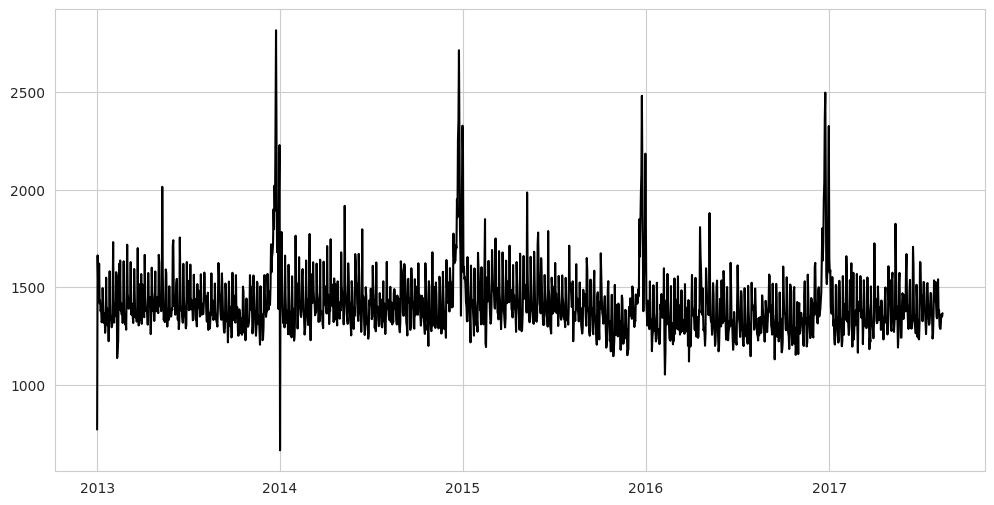

In [53]:
transactions["date"] = pd.to_datetime(transactions["date"])  # Convert to datetime format

# Group by 'date' and calculate the median of transactions for each date
med_trans = transactions.groupby("date")["transactions"].median().reset_index(name="med_trans")

# Plot
plt.figure(figsize=(12, 6))

# Plot the median transaction line
plt.plot(med_trans['date'], med_trans['med_trans'], color="black", label="Median Transactions")

# Plot the smoothed line using LOESS (locally estimated scatterplot smoothing)
sns.regplot(x='date', y='med_trans', data=med_trans, scatter=False, color="red", lowess=True, line_kws={"color": "red", "linewidth": 2, "alpha": 0.6})

# Labels and Title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Median Transactions", fontsize=12)
plt.title("Median Transactions with LOESS Smoothing", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
# We find that there is a strong spike before Christmas, with corresponding drops when the stores are presumably closed during the holidays.

# **Train data**

In [ ]:
train.head()